In [88]:
import os
import h5py
from scipy.io import loadmat
import numpy as np
import random
from preproc import *
from itertools import combinations
from scipy.special import factorial
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from matplotlib.widgets import Slider
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
import textwrap
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, ClassifierMixin



In [89]:
# Choose which days to include
#day_list = ['20181105', '20181102', '20181101']

# Or, read in list of days from txt file
day_list = list()
with open(f'data/combined/days.txt', 'r') as file:
    for line in file:
        day_list.append(line.strip())

num_sess = len(day_list)
num_goals = 6
tbin_size = 0.1

In [90]:
good_cell_labels = list()
with open('data/cell_list_hm.txt', 'r') as file:
    for line in file:
        line = line.strip().split('/')
        good_cell_labels.append(f'{line[5]}ch{str(int(line[8][7:]))}c{str(int(line[9][4:]))}')
print(good_cell_labels)

['20181105ch29c1', '20181105ch30c1', '20181105ch43c1', '20181105ch43c2', '20181105ch43c3', '20181105ch45c1', '20181102ch9c1', '20181102ch19c1', '20181102ch19c2', '20181102ch26c1', '20181102ch26c2', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181102ch45c1', '20181102ch45c2', '20181101ch19c1', '20181101ch19c2', '20181101ch21c1', '20181101ch23c1', '20181101ch29c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c1', '20181101ch30c2', '20181101ch35c1', '20181101ch43c1', '20181101ch45c1', '20181031ch19c1', '20181031ch19c2', '20181031ch19c3', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch30c2', '20181031ch35c1', '20181031ch35c2', '20181031ch35c3', '20181031ch43c1', '20181031ch43c2', '20181031ch45c1', '20181031ch45c2', '20181026ch19c1', '20181026ch19c2', '20181026ch19c3', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch35c3', '20181026c

In [91]:
# Save directory for data files
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
save_dir = "data/placedist"
# Whether to overwrite preexisting files
overwrite = True

In [92]:
#Read placeist files
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        all_place_responses.extend(data['place_responses_per_cell'])
        for _ in range(num_sess_cells):
            all_place_durations.append(data['durations_per_place'])
        all_cell_labels.extend(data['cell_labels'])

In [ ]:
del all_place_durations
del all_place_responses

In [ ]:
new_list_labels = list()
for cell_label in all_cell_labels:
    if cell_label in good_cell_labels:
        new_list_labels.append(cell_label)
print(len(new_list_labels))

364


In [ ]:
# Set amount of bins, see which cells are valid for testing 
total_bins = 23
two_thirds = 16
valid_cells_distribution = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in good_cell_labels:
            continue
        total_valid_bins = list()
        # if 2/3 of the bins contain over 30 samples, the cell is valid
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if dist.size > 30:
                total_valid_bins.append(bin)

        if len(total_valid_bins) > two_thirds:
            valid_cells_distribution.append(label)
print('Amount of valid cells:', len(valid_cells_distribution))
train_size = int(round((len(valid_cells_distribution) * 0.7),0))
test_size = int(round((len(valid_cells_distribution) * 0.3),0))
print(train_size)
print(test_size)
print(valid_cells_distribution)
list_nums = list(range(1,(len(valid_cells_distribution) + 1)))
valid_cell_to_num = dict(zip(valid_cells_distribution, list_nums))
print(valid_cell_to_num)


Amount of valid cells: 223
156
67
['20181105ch43c1', '20181105ch43c3', '20181105ch45c1', '20181102ch19c1', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c2', '20181101ch19c1', '20181101ch21c1', '20181101ch29c3', '20181101ch29c4', '20181101ch30c2', '20181101ch43c1', '20181031ch19c2', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch43c1', '20181031ch43c2', '20181026ch19c1', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch45c1', '20181022ch9c1', '20181022ch26c1', '20181022ch29c1', '20181022ch43c1', '20181022ch43c4', '20181022ch45c1', '20181017ch29c1', '20181017ch45c1', '20181016ch20c1', '20181016ch29c1', '20181016ch45c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c1', '20181011ch20c1', '20181011ch29c1', '20181011ch45c1', '20181011ch45c2', '20181010ch45c1', '20181009ch45c1', '20181009ch45c4', '20181005ch45c4', '20181005ch45c1', '20181005ch45c2', '20181005ch45c3', '20181004ch45c1', '20181004ch4

In [ ]:
bins_length = []
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in valid_cells_distribution:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            bins_length.append(len(dist))
print(bins_length)
Q1 = np.percentile(bins_length, 25)
Q3 = np.percentile(bins_length, 75)

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")

bins_data = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in valid_cells_distribution:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data:
                bins_data[bin] = []
            if (len(dist) < Q3 and len(dist) > Q1):
                bins_data[bin].append(dist)

[210, 300, 601, 344, 187, 110, 365, 212, 87, 345, 193, 153, 40, 132, 155, 184, 58, 23, 89, 22, 108, 259, 415, 834, 443, 230, 173, 496, 311, 132, 507, 269, 174, 52, 185, 189, 261, 58, 35, 130, 44, 205, 80, 148, 179, 157, 67, 64, 150, 89, 49, 152, 77, 110, 23, 50, 98, 102, 25, 18, 31, 20, 49, 261, 142, 44, 202, 501, 697, 1102, 421, 183, 554, 326, 608, 334, 159, 47, 197, 343, 225, 56, 100, 384, 145, 82, 33, 128, 251, 345, 473, 218, 108, 267, 155, 245, 176, 75, 22, 114, 168, 116, 49, 72, 172, 225, 125, 42, 178, 468, 569, 920, 382, 154, 521, 298, 492, 287, 149, 36, 160, 287, 194, 51, 93, 335, 202, 110, 33, 128, 327, 436, 715, 326, 116, 380, 201, 367, 201, 106, 28, 105, 228, 179, 44, 67, 276, 329, 188, 56, 270, 663, 911, 1444, 564, 249, 739, 403, 794, 430, 208, 56, 243, 432, 293, 81, 138, 515, 235, 132, 43, 184, 466, 653, 1014, 418, 172, 537, 284, 560, 324, 141, 36, 177, 304, 212, 54, 102, 372, 275, 389, 954, 702, 360, 212, 388, 286, 214, 211, 163, 50, 219, 62, 597, 284, 216, 56, 180, 44, 15

In [ ]:
X = []
y = []
bin_list = [1,2,3,4,5,6,8,10,11,12,13,14,15,16,18,20,21,22,23,24,25]
for i in bin_list:
    temp_list = bins_data[i]
    X.extend(temp_list)
    y.extend([i] * len(bins_data[i]))

In [ ]:
max_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_length, padding='post', dtype='float32')
y = np.asarray(y)
print(X_padded.shape)

(2323, 286)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.21, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
accuracy_random_forst = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

Accuracy: 0.1885245901639344
Classification Report:
              precision    recall  f1-score   support

           1       0.38      0.75      0.50         4
           2       0.15      0.19      0.17        36
           3       0.18      0.14      0.15        37
           4       0.36      0.31      0.33        42
           5       0.00      0.00      0.00         1
           6       0.17      0.25      0.20        32
           8       0.08      0.05      0.06        21
          10       0.15      0.21      0.18        33
          11       0.11      0.07      0.09        28
          12       0.09      0.12      0.11         8
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         8
          15       0.21      0.12      0.16        32
          16       0.13      0.14      0.14        35
          18       0.14      0.09      0.11        23
          20       0.15      0.13      0.14        39
          22       0.38      

/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
mse_random_forest_regressor = mean_squared_error(y_test, y_pred)

Mean Squared Error: 58.434556774193545


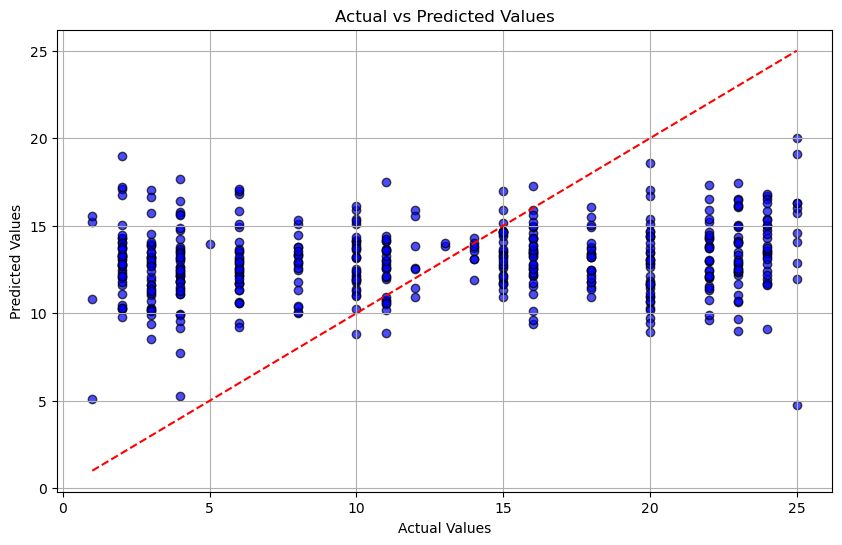

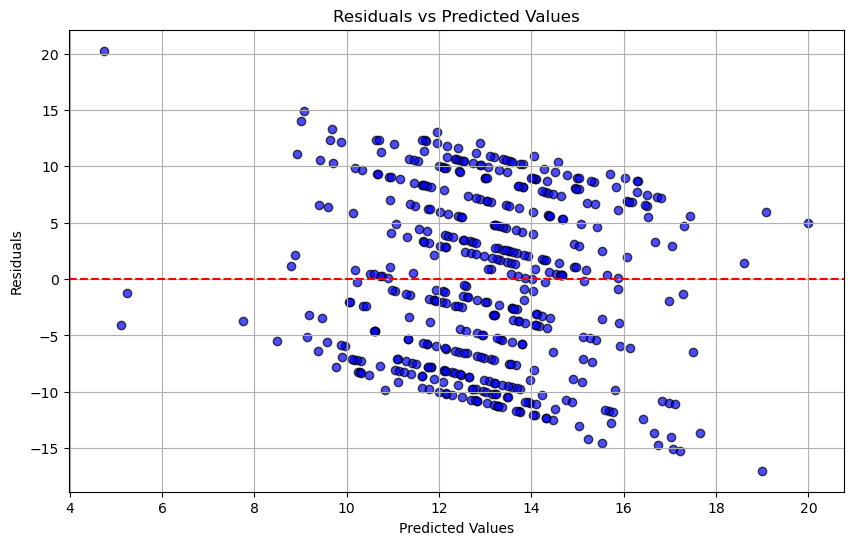

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_decision_tree_classifier = accuracy_score(y_test, y_pred)
print(accuracy_decision_tree_classifier)
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

0.16559139784946236
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.15      0.14      0.14        36
           3       0.22      0.20      0.21        35
           4       0.32      0.27      0.29        41
           5       0.00      0.00      0.00         1
           6       0.09      0.09      0.09        32
           8       0.11      0.15      0.12        20
          10       0.13      0.10      0.11        31
          11       0.19      0.19      0.19        26
          12       0.14      0.29      0.19         7
          13       0.00      0.00      0.00         2
          14       0.12      0.12      0.12         8
          15       0.17      0.14      0.15        28
          16       0.12      0.09      0.10        34
          18       0.16      0.13      0.14        23
          20       0.17      0.16      0.16        37
          22       0.37      0.38     

In [ ]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC(kernel='poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

Accuracy Score: 0.12903225806451613
Classification Report:
              precision    recall  f1-score   support

           1       0.14      0.25      0.18         4
           2       0.13      0.17      0.14        36
           3       0.06      0.06      0.06        35
           4       0.28      0.24      0.26        41
           5       0.00      0.00      0.00         1
           6       0.16      0.22      0.18        32
           8       0.04      0.05      0.05        20
          10       0.17      0.23      0.20        31
          11       0.08      0.12      0.09        26
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         8
          15       0.04      0.04      0.04        28
          16       0.15      0.15      0.15        34
          18       0.12      0.09      0.10        23
          20       0.11      0.05      0.07        37
          22       0.2

/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Accuracy Score: 0.1010752688172043
Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.50      0.44         4
           2       0.07      0.08      0.07        36
           3       0.12      0.03      0.05        35
           4       0.15      0.20      0.17        41
           5       0.00      0.00      0.00         1
           6       0.10      0.06      0.08        32
           8       0.00      0.00      0.00        20
          10       0.03      0.06      0.04        31
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         8
          15       0.25      0.07      0.11        28
          16       0.11      0.29      0.16        34
          18       0.00      0.00      0.00        23
          20       0.10      0.05      0.07        37
          22       0.15

/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Accuracy Score: 0.1010752688172043
Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.50      0.44         4
           2       0.07      0.08      0.07        36
           3       0.12      0.03      0.05        35
           4       0.15      0.20      0.17        41
           5       0.00      0.00      0.00         1
           6       0.10      0.06      0.08        32
           8       0.00      0.00      0.00        20
          10       0.03      0.06      0.04        31
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         8
          15       0.25      0.07      0.11        28
          16       0.11      0.29      0.16        34
          18       0.00      0.00      0.00        23
          20       0.10      0.05      0.07        37
          22       0.15

/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.22, random_state=42)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.103515625
Classification Report:
              precision    recall  f1-score   support

           1       0.17      0.25      0.20         4
           2       0.12      0.11      0.11        37
           3       0.07      0.05      0.06        41
           4       0.21      0.16      0.18        43
           5       0.00      0.00      0.00         1
           6       0.13      0.12      0.13        32
           8       0.00      0.00      0.00        21
          10       0.12      0.14      0.13        35
          11       0.08      0.10      0.09        29
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         8
          15       0.03      0.03      0.03        35
          16       0.07      0.08      0.07        37
          18       0.17      0.17      0.17        23
          20       0.07      0.05      0.06        40
          21       0.00      0.00   

/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(probability=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
lda = LinearDiscriminantAnalysis()

models = {
    'Random Forest': rf,
    'SVM': svm,
    'Decision Tree': dt,
    'LDA': lda
}

rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
dt.fit(X_train, y_train)
lda.fit(X_train, y_train)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")

Random Forest Accuracy: 0.18494623655913978
Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.08      0.11      0.09        36
           3       0.19      0.11      0.14        35
           4       0.37      0.34      0.35        41
           5       0.00      0.00      0.00         1
           6       0.21      0.28      0.24        32
           8       0.18      0.10      0.13        20
          10       0.10      0.13      0.11        31
          11       0.07      0.04      0.05        26
          12       0.19      0.43      0.26         7
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         8
          15       0.09      0.07      0.08        28
          16       0.21      0.26      0.23        34
          18       0.13      0.09      0.11        23
          20       0.21      0.16      0.18        37


/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

SVM Accuracy: 0.1010752688172043
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.50      0.44         4
           2       0.07      0.08      0.07        36
           3       0.12      0.03      0.05        35
           4       0.15      0.20      0.17        41
           5       0.00      0.00      0.00         1
           6       0.10      0.06      0.08        32
           8       0.00      0.00      0.00        20
          10       0.03      0.06      0.04        31
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         8
          15       0.25      0.07      0.11        28
          16       0.11      0.29      0.16        34
          18       0.00      0.00      0.00        23
          20       0.10      0.05      0.07        37
          22       0.

/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Decision Tree Accuracy: 0.16989247311827957
Decision Tree Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.16      0.17      0.16        36
           3       0.19      0.17      0.18        35
           4       0.33      0.27      0.30        41
           5       0.50      1.00      0.67         1
           6       0.10      0.12      0.11        32
           8       0.08      0.10      0.09        20
          10       0.22      0.19      0.21        31
          11       0.14      0.12      0.13        26
          12       0.13      0.29      0.18         7
          13       0.00      0.00      0.00         2
          14       0.12      0.12      0.12         8
          15       0.17      0.18      0.17        28
          16       0.07      0.06      0.07        34
          18       0.33      0.26      0.29        23
          20       0.20      0.14      0.16        37


/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('svm', svm),
    ('dt', dt),
    ('lda', lda)
], voting='soft')    
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Voting Classifier Accuracy: {accuracy}")
print(f"Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

Voting Classifier Accuracy: 0.17634408602150536
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.12      0.25      0.17         4
           2       0.16      0.17      0.16        36
           3       0.19      0.17      0.18        35
           4       0.35      0.29      0.32        41
           5       0.00      0.00      0.00         1
           6       0.11      0.12      0.12        32
           8       0.09      0.10      0.09        20
          10       0.21      0.19      0.20        31
          11       0.17      0.12      0.14        26
          12       0.14      0.29      0.19         7
          13       0.00      0.00      0.00         2
          14       0.12      0.12      0.12         8
          15       0.16      0.18      0.17        28
          16       0.07      0.06      0.06        34
          18       0.33      0.26      0.29        23
          20       0.20      0.14      0.16   

In [ ]:
class CustomVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators, class_weights):
        self.estimators = estimators
        self.class_weights = class_weights
        self.class_labels = None
    
    def fit(self, X, y):
        self.models_ = []
        for name, model in self.estimators:
            model.fit(X, y)
            self.models_.append(model)
        
        self.class_labels = np.unique(y)
        return self
    
    def predict(self, X):
        probas = np.zeros((X.shape[0], len(self.class_labels)))
        for model in self.models_:
            probas += model.predict_proba(X)
        
        weighted_probas = np.zeros_like(probas)
        for class_idx, class_label in enumerate(self.class_labels):
            for model_idx, model in enumerate(self.models_):
                class_index_in_probas = np.where(self.class_labels == class_label)[0][0]
                weighted_probas[:, class_idx] += probas[:, class_index_in_probas] * self.class_weights[class_label][model_idx]
        
        weighted_probas /= np.sum([weight for weights in self.class_weights.values() for weight in weights])
        
        return self.class_labels[np.argmax(weighted_probas, axis=1)]

In [ ]:
bin_list = [1,2,3,4,5,6,8,10,11,12,13,14,15,16,18,20,21,22,23,24,25]

estimators = [
    ('rf', rf),
    ('svm', svm),
    ('dt', dt),
    ('lda', lda)
]

class_weights = {
    1: [1.0, 1.0, 1.0, 1.0],
    2: [1.0, 1.0, 1.0, 1.0],
    3: [1.0, 1.0, 1.0, 1.0],
    4: [1.0, 1.0, 1.0, 1.0],
    5: [1.0, 1.0, 1.0, 1.0],
    6: [1.0, 1.0, 1.0, 1.0],
    8: [1.0, 1.0, 1.0, 1.0],
    10: [1.0, 1.0, 1.0, 1.0],
    11: [1.0, 1.0, 1.0, 1.0],
    12: [1.0, 1.0, 1.0, 1.0],
    13: [1.0, 1.0, 1.0, 1.0],
    14: [1.0, 1.0, 1.0, 1.0],
    15: [1.0, 1.0, 1.0, 1.0],
    16: [1.0, 1.0, 1.0, 1.0],
    18: [1.0, 1.0, 1.0, 1.0],
    20: [1.0, 1.0, 1.0, 1.0],
    21: [1.0, 1.0, 1.0, 1.0],
    22: [1.0, 1.0, 1.0, 1.0],
    23: [1.0, 1.0, 1.0, 1.0],
    24: [1.0, 1.0, 1.0, 1.0],
    25: [1.0, 1.0, 1.0, 1.0]
}
custom_voting_clf = CustomVotingClassifier(estimators=estimators, class_weights=class_weights)
custom_voting_clf.fit(X_train, y_train)

y_pred = custom_voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Custom Voting Classifier Accuracy: {accuracy}")
print(f"Custom Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

Custom Voting Classifier Accuracy: 0.17634408602150536
Custom Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.12      0.25      0.17         4
           2       0.16      0.17      0.16        36
           3       0.19      0.17      0.18        35
           4       0.35      0.29      0.32        41
           5       0.00      0.00      0.00         1
           6       0.11      0.12      0.12        32
           8       0.09      0.10      0.09        20
          10       0.21      0.19      0.20        31
          11       0.17      0.12      0.14        26
          12       0.14      0.29      0.19         7
          13       0.00      0.00      0.00         2
          14       0.12      0.12      0.12         8
          15       0.16      0.18      0.17        28
          16       0.07      0.06      0.06        34
          18       0.33      0.26      0.29        23
          20       0.20      0.1